In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# EDA

In [2]:
# Load the dataset
file_path = 'Oesophagal_Risk_ML_Predictor.csv'
data = pd.read_csv(file_path)

## Understanding Data

In [3]:
data.head()

,Rest Saturation,Systolic,Diastolic,HR-CT,Comorbidities,Gender,Smoker,Risk Coefficient(Predictor),Unnamed: 8,Unnamed: 9,Unnamed: 10
0,96.0,118.0,78.0,21.0,True,F,YES,HIGH,NaN,Classification Problem,NaN
1,98.0,140.0,67.0,20.0,False,M,NO,LOW,NaN,Predictor,"Risk Coefficient( 2 levels,high and Low)"
2,96.0,135.0,83.0,22.0,True,M,NO,HIGH,NaN,Independent Variables,Columns A:G
3,97.0,118.0,86.0,25.0,True,F,YES,HIGH,NaN,NaN,NaN
4,95.0,120.0,88.0,3.0,False,M,YES,LOW,NaN,Rest Saturation,"Resting oxygen saturation,measured on a scale ..."


In [4]:
# Drop irrelevant columns
data_cleaned = data.drop(columns=['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])

In [5]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5100 entries, 0 to 5099
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Rest Saturation              5098 non-null   float64
 1   Systolic                     5097 non-null   float64
 2   Diastolic                    5098 non-null   float64
 3   HR-CT                        5097 non-null   float64
 4   Comorbidities                5096 non-null   object 
 5   Gender                       5095 non-null   object 
 6   Smoker                       5098 non-null   object 
 7   Risk Coefficient(Predictor)  5100 non-null   object 
dtypes: float64(4), object(4)
memory usage: 318.9+ KB


In [6]:
data_cleaned.isnull().sum()

Rest Saturation                2
Systolic                       3
Diastolic                      2
HR-CT                          3
Comorbidities                  4
Gender                         5
Smoker                         2
Risk Coefficient(Predictor)    0
dtype: int64

In [7]:
data_cleaned.head()

,Rest Saturation,Systolic,Diastolic,HR-CT,Comorbidities,Gender,Smoker,Risk Coefficient(Predictor)
0,96.0,118.0,78.0,21.0,True,F,YES,HIGH
1,98.0,140.0,67.0,20.0,False,M,NO,LOW
2,96.0,135.0,83.0,22.0,True,M,NO,HIGH
3,97.0,118.0,86.0,25.0,True,F,YES,HIGH
4,95.0,120.0,88.0,3.0,False,M,YES,LOW


In [8]:
data_cleaned.shape

(5100, 8)

In [9]:
data_cleaned['Risk Coefficient(Predictor)'].value_counts()

Risk Coefficient(Predictor)
HIGH    2567
LOW     2533
Name: count, dtype: int64

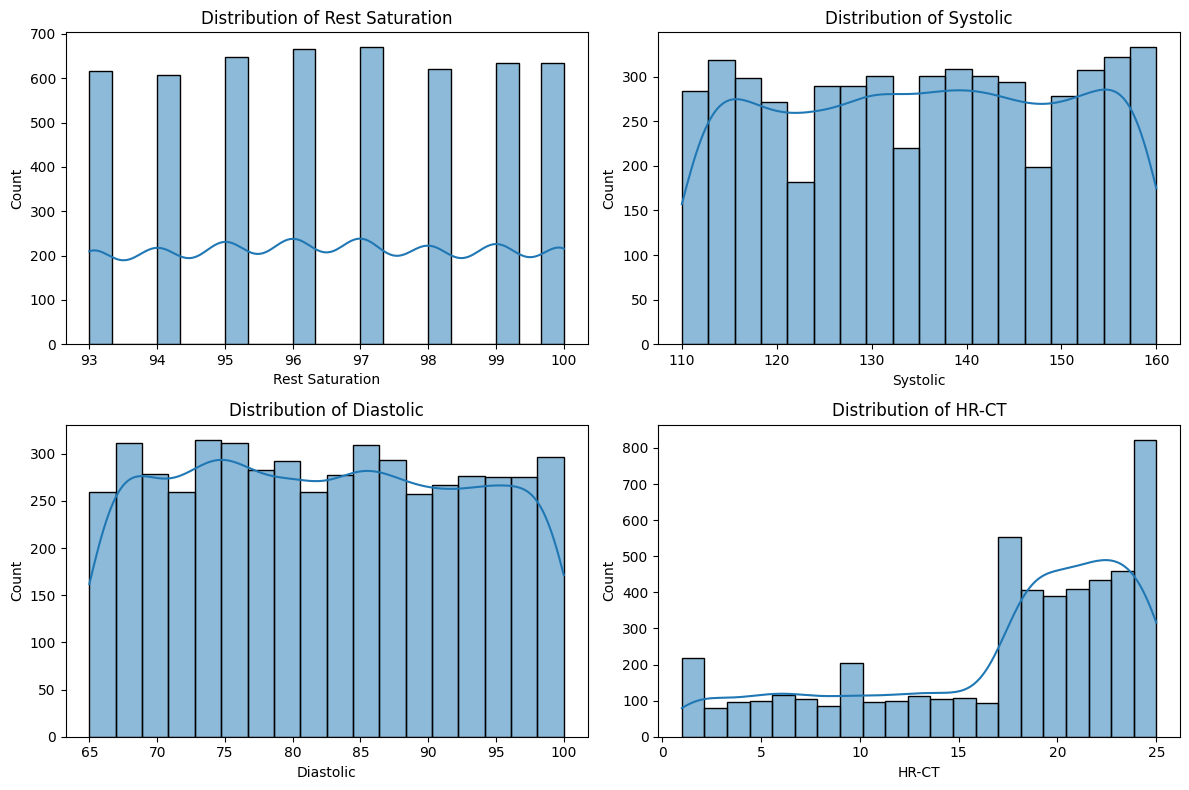

In [10]:
# Histograms for numerical features
numerical_columns = ['Rest Saturation', 'Systolic', 'Diastolic', 'HR-CT']
plt.figure(figsize=(12, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[column].dropna(), kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

## Data Preparation


### Handling missing data

In [11]:
# 1. Dropping rows with missing values
data_dropped = data_cleaned.dropna()

In [12]:
# 2. Imputation (median for numerical, mode for categorical)
data_imputed = data_cleaned.copy()
numerical_columns = ['Rest Saturation', 'Systolic', 'Diastolic', 'HR-CT']
categorical_columns = ['Comorbidities', 'Gender', 'Smoker']

for column in numerical_columns:
    data_imputed[column].fillna(data_imputed[column].median(), inplace=True)

for column in categorical_columns:
    data_imputed[column].fillna(data_imputed[column].mode()[0], inplace=True)

In [13]:
# 3. Interpolation for numerical and mode for categorical
data_interpolated = data_cleaned.copy()
data_interpolated[numerical_columns] = data_interpolated[numerical_columns].interpolate()

for column in categorical_columns:
    data_interpolated[column].fillna(data_interpolated[column].mode()[0], inplace=True)

### Encoding

In [14]:
def encode_data(df):
    df_encoded = df.copy()
    if'Risk Coefficient(Predictor)' in df_encoded.columns:
        df_encoded['Risk Coefficient(Predictor)'] = df_encoded['Risk Coefficient(Predictor)'].map({'HIGH': 1, 'LOW': 0})
    if 'Comorbidities' in df_encoded.columns:
        df_encoded['Comorbidities'] = df_encoded['Comorbidities'].map({True: 1, False: 0})
    if 'Gender' in df_encoded.columns:
        df_encoded['Gender'] = df_encoded['Gender'].map({'F': 0, 'M': 1})
    if 'Smoker' in df_encoded.columns:
        df_encoded['Smoker'] = df_encoded['Smoker'].map({'YES': 1, 'NO': 0})
    return df_encoded

In [15]:
data_dropped_encoded = encode_data(data_dropped)
data_imputed_encoded = encode_data(data_imputed)
data_interpolated_encoded = encode_data(data_interpolated)

### General Statistical Analysis


In [16]:
data_dropped_encoded.describe()

,Rest Saturation,Systolic,Diastolic,HR-CT,Comorbidities,Gender,Smoker,Risk Coefficient(Predictor)
count,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000
mean,96.516421,135.367355,82.423402,17.275713,0.566175,0.485939,0.505408,0.503245
std,2.270543,14.817084,10.364174,6.816717,0.495650,0.499851,0.500020,0.500039
min,93.000000,110.000000,65.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,95.000000,123.000000,74.000000,13.000000,0.000000,0.000000,0.000000,0.000000
50%,97.000000,136.000000,82.000000,19.000000,1.000000,0.000000,1.000000,1.000000
75%,98.000000,148.000000,91.000000,23.000000,1.000000,1.000000,1.000000,1.000000
max,100.000000,160.000000,100.000000,25.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
data_imputed_encoded.describe()

,Rest Saturation,Systolic,Diastolic,HR-CT,Comorbidities,Gender,Smoker,Risk Coefficient(Predictor)
count,5100.000000,5100.00000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000
mean,96.517843,135.36549,82.412941,17.281176,0.566471,0.485686,0.505882,0.503333
std,2.270205,14.81474,10.366063,6.814650,0.495611,0.499844,0.500014,0.500038
min,93.000000,110.00000,65.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,95.000000,123.00000,74.000000,13.000000,0.000000,0.000000,0.000000,0.000000
50%,97.000000,136.00000,82.000000,19.000000,1.000000,0.000000,1.000000,1.000000
75%,98.000000,148.00000,91.000000,23.000000,1.000000,1.000000,1.000000,1.000000
max,100.000000,160.00000,100.000000,25.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
data_interpolated_encoded.describe()

,Rest Saturation,Systolic,Diastolic,HR-CT,Comorbidities,Gender,Smoker,Risk Coefficient(Predictor)
count,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000
mean,96.518333,135.362255,82.412843,17.279706,0.566471,0.485686,0.505882,0.503333
std,2.270492,14.817091,10.366126,6.815031,0.495611,0.499844,0.500014,0.500038
min,93.000000,110.000000,65.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,95.000000,123.000000,74.000000,13.000000,0.000000,0.000000,0.000000,0.000000
50%,97.000000,136.000000,82.000000,19.000000,1.000000,0.000000,1.000000,1.000000
75%,98.000000,148.000000,91.000000,23.000000,1.000000,1.000000,1.000000,1.000000
max,100.000000,160.000000,100.000000,25.000000,1.000000,1.000000,1.000000,1.000000


### Class-wise Statistical Analysis


In [19]:
Risk_high = data_dropped_encoded[data_dropped_encoded['Risk Coefficient(Predictor)'] == 1]
Risk_high.describe()

,Rest Saturation,Systolic,Diastolic,HR-CT,Comorbidities,Gender,Smoker,Risk Coefficient(Predictor)
count,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2559.0
mean,96.500586,135.618992,82.436499,21.512700,0.570926,0.493552,0.509965,1.0
std,2.267987,14.834921,10.327957,2.302847,0.495041,0.500056,0.499998,0.0
min,93.000000,110.000000,65.000000,18.000000,0.000000,0.000000,0.000000,1.0
25%,95.000000,123.000000,74.000000,19.000000,0.000000,0.000000,0.000000,1.0
50%,96.000000,136.000000,82.000000,22.000000,1.000000,0.000000,1.000000,1.0
75%,98.000000,148.000000,91.000000,23.000000,1.000000,1.000000,1.000000,1.0
max,100.000000,160.000000,100.000000,25.000000,1.000000,1.000000,1.000000,1.0


In [20]:
Risk_low = data_dropped_encoded[data_dropped_encoded['Risk Coefficient(Predictor)'] == 0]
Risk_low.describe()

,Rest Saturation,Systolic,Diastolic,HR-CT,Comorbidities,Gender,Smoker,Risk Coefficient(Predictor)
count,2526.000000,2526.000000,2526.000000,2526.000000,2526.000000,2526.000000,2526.000000,2526.0
mean,96.532462,135.112431,82.410135,12.983373,0.561362,0.478226,0.500792,0.0
std,2.273466,14.797566,10.402762,7.180758,0.496319,0.499625,0.500098,0.0
min,93.000000,110.000000,65.000000,1.000000,0.000000,0.000000,0.000000,0.0
25%,95.000000,122.000000,73.000000,7.000000,0.000000,0.000000,0.000000,0.0
50%,97.000000,135.000000,82.000000,13.000000,1.000000,0.000000,1.000000,0.0
75%,99.000000,148.000000,91.000000,19.000000,1.000000,1.000000,1.000000,0.0
max,100.000000,160.000000,100.000000,25.000000,1.000000,1.000000,1.000000,0.0


### Uni-variate Data Analysis


#### Distribution Plots
##### Distribution plots, also known as probability density function (PDF) plots, show how values in a dataset are spread out. They help us see the shape of the data distribution and identify patterns.

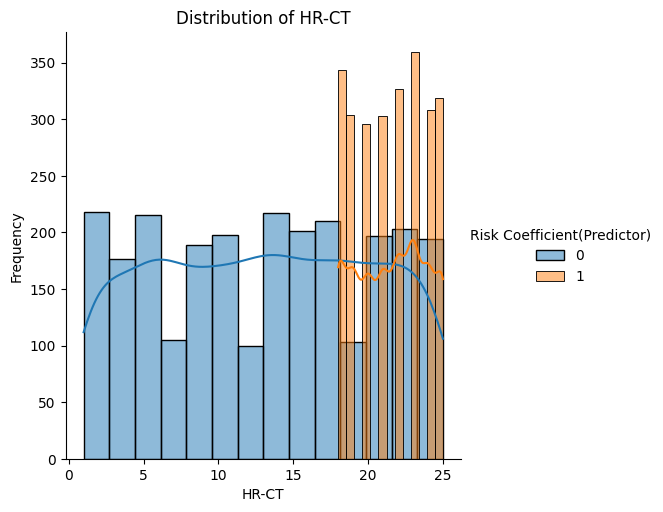

In [21]:
sns.FacetGrid(data_dropped_encoded, hue="Risk Coefficient(Predictor)", height=5).map(sns.histplot, "HR-CT", kde=True).add_legend()
plt.title('Distribution of HR-CT')
plt.xlabel('HR-CT')
plt.ylabel('Frequency')
plt.show()

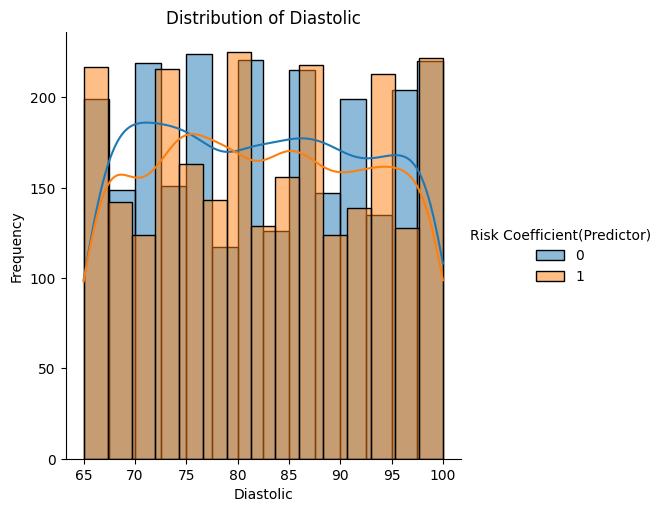

In [22]:
sns.FacetGrid(data_dropped_encoded, hue="Risk Coefficient(Predictor)", height=5).map(sns.histplot, "Diastolic", kde=True).add_legend()
plt.title('Distribution of Diastolic')
plt.xlabel('Diastolic')
plt.ylabel('Frequency')
plt.show()

#### Cumulative Distribution Function (CDF)
##### CDF plots show the probability that a variable will take a value less than or equal to a specific value. They provide a cumulative measure of the distribution.

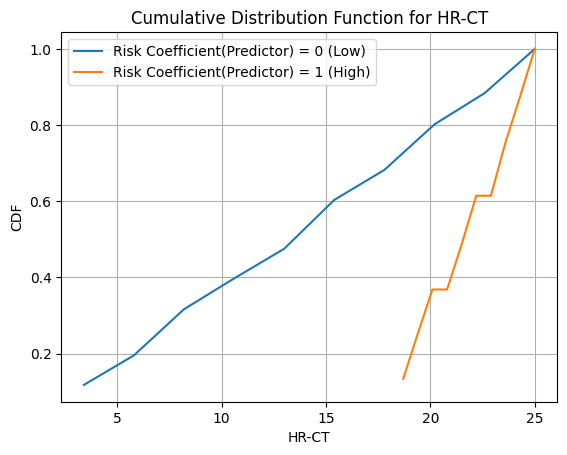

In [23]:
import numpy as np

counts, bin_edges = np.histogram(data_dropped_encoded[data_dropped_encoded['Risk Coefficient(Predictor)'] == 0]['HR-CT'], density=True)
pdf = counts / sum(counts)
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf, label='Risk Coefficient(Predictor) = 0 (Low)')

counts, bin_edges = np.histogram(data_dropped_encoded[data_dropped_encoded['Risk Coefficient(Predictor)'] == 1]['HR-CT'], density=True)
pdf = counts / sum(counts)
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf, label='Risk Coefficient(Predictor) = 1 (High)')

plt.legend()
plt.xlabel("HR-CT")
plt.ylabel("CDF")
plt.title('Cumulative Distribution Function for HR-CT')
plt.grid()
plt.show()


#### Boxplots

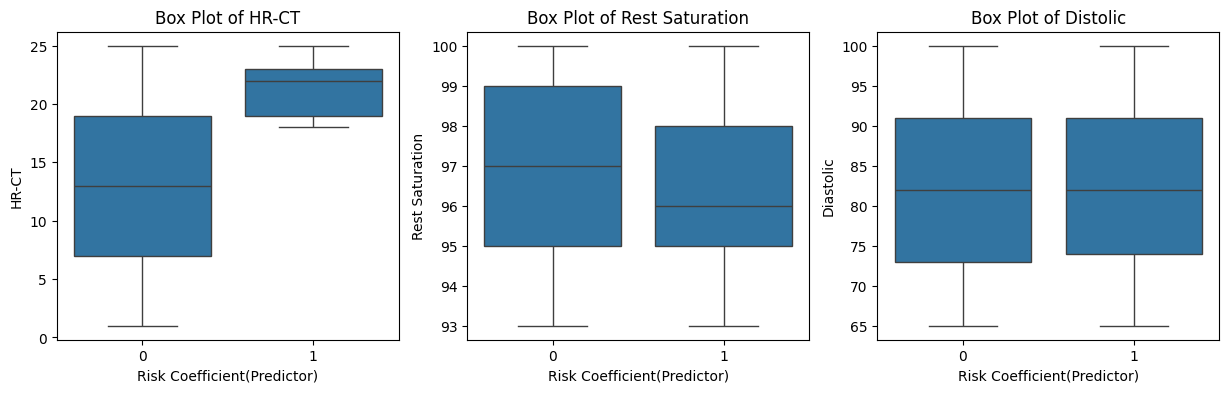

In [24]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
sns.boxplot(x='Risk Coefficient(Predictor)', y='HR-CT', data=data_dropped_encoded)
plt.title('Box Plot of HR-CT')
plt.subplot(1, 3, 2)
sns.boxplot(x='Risk Coefficient(Predictor)', y='Rest Saturation', data=data_dropped_encoded)
plt.title('Box Plot of Rest Saturation')
plt.subplot(1, 3, 3)
sns.boxplot(x='Risk Coefficient(Predictor)', y='Diastolic', data=data_dropped_encoded)
plt.title('Box Plot of Distolic')
plt.show()

#### Violin Plots

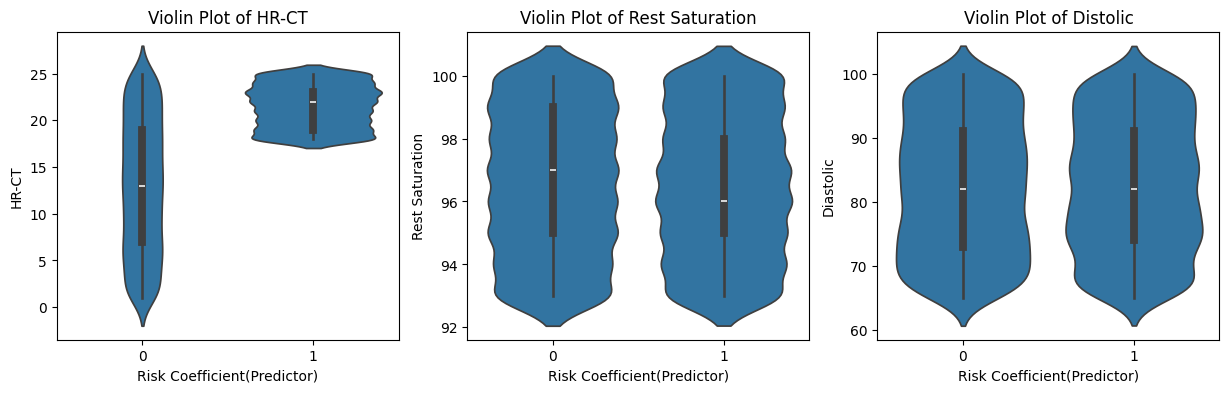

In [25]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
sns.violinplot(x='Risk Coefficient(Predictor)', y='HR-CT', data=data_dropped_encoded)
plt.title('Violin Plot of HR-CT')
plt.subplot(1, 3, 2)
sns.violinplot(x='Risk Coefficient(Predictor)', y='Rest Saturation', data=data_dropped_encoded)
plt.title('Violin Plot of Rest Saturation')
plt.subplot(1, 3, 3)
sns.violinplot(x='Risk Coefficient(Predictor)', y='Diastolic', data=data_dropped_encoded)
plt.title('Violin Plot of Distolic')
plt.show()

#### Bar chart

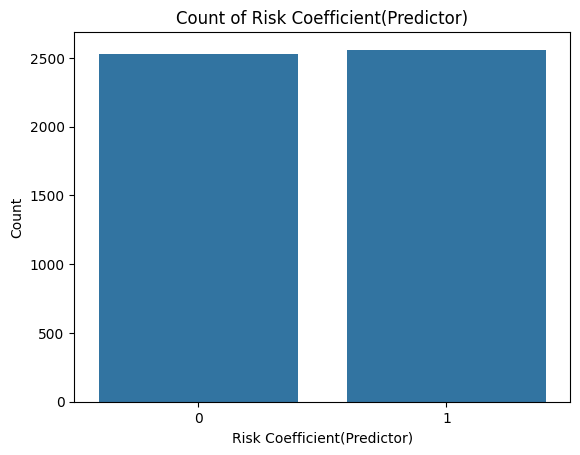

In [26]:
sns.countplot(x='Risk Coefficient(Predictor)', data=data_dropped_encoded)
plt.title('Count of Risk Coefficient(Predictor)')
plt.xlabel('Risk Coefficient(Predictor)')
plt.ylabel('Count')
plt.show()

#### Histogram

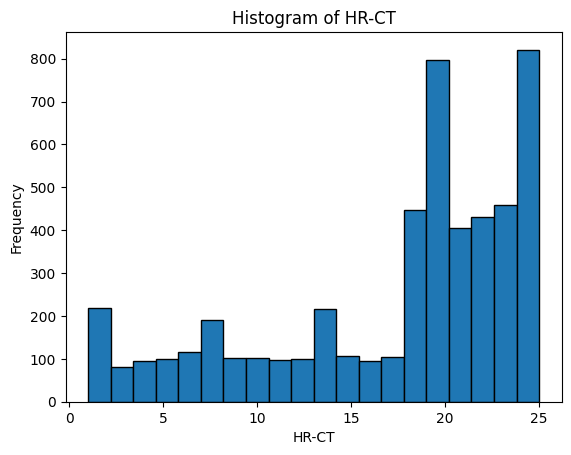

In [27]:
data_dropped_encoded['HR-CT'].plot(kind='hist', bins=20, edgecolor='black')
plt.title('Histogram of HR-CT')
plt.xlabel('HR-CT')
plt.ylabel('Frequency')
plt.show()

### Bi-variate Data Analysis
#### Bi-variate data analysis involves studying the relationship between two variables at a time. This helps in understanding how one variable affects another and can reveal underlying patterns or correlations. Here are some common methods for bi-variate analysis.

#### Pair Plot


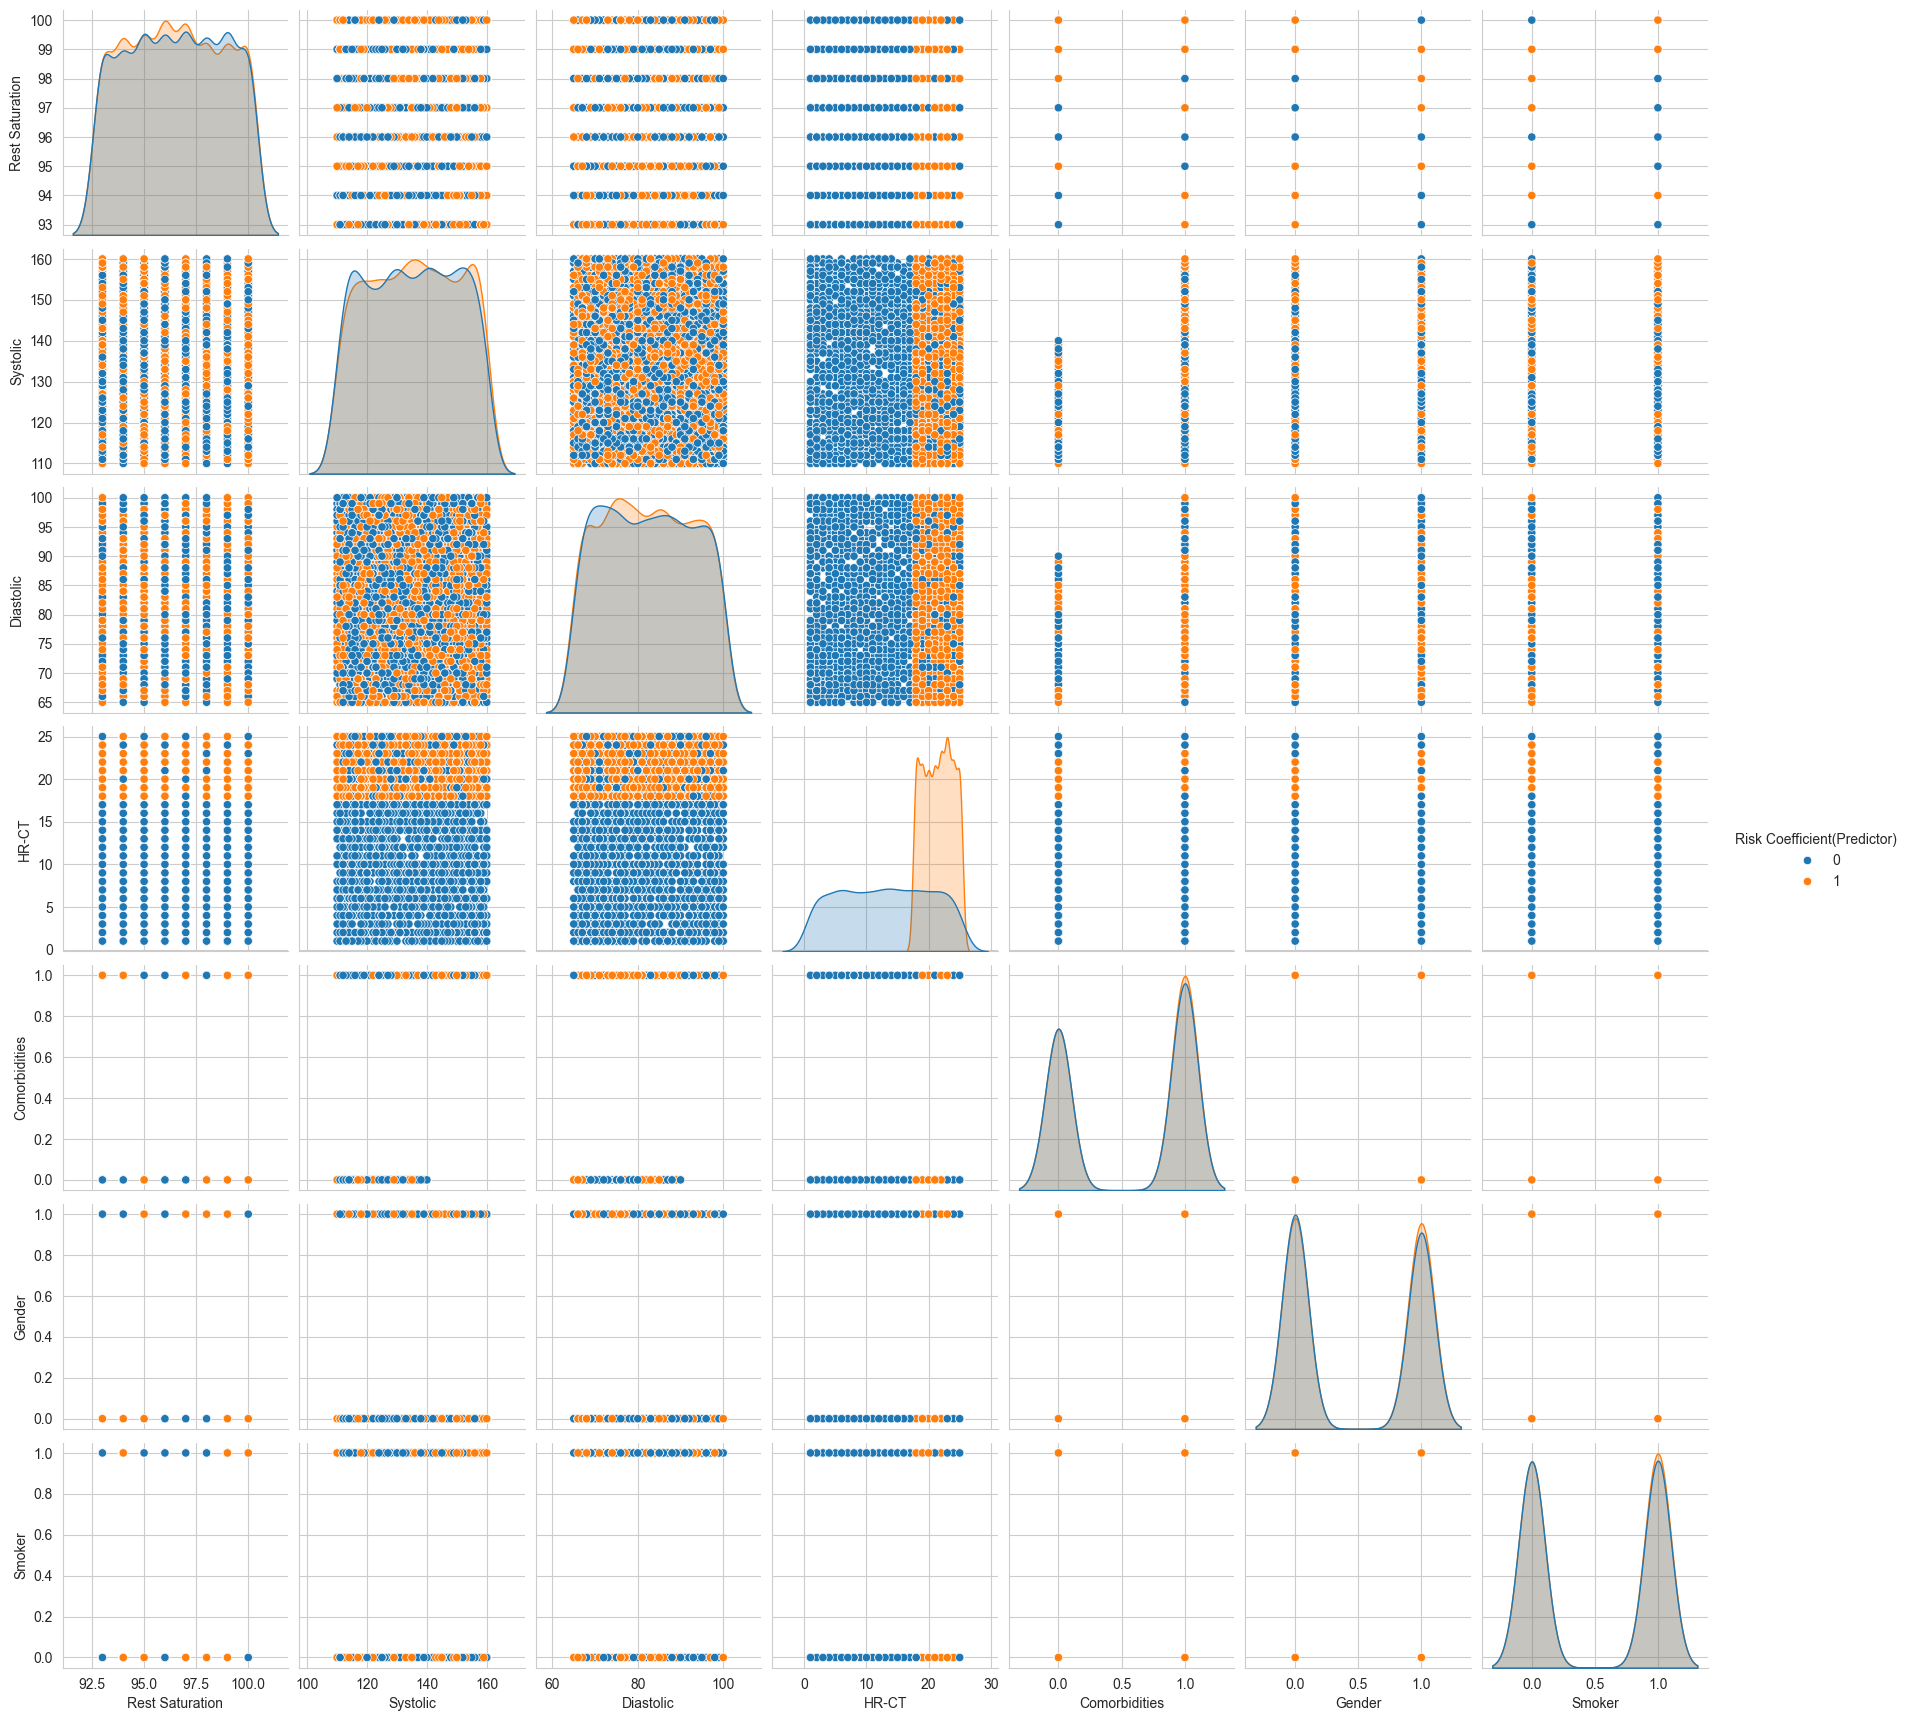

In [28]:
sns.set_style('whitegrid')
sns.pairplot(data_dropped_encoded, hue='Risk Coefficient(Predictor)')
plt.show()


#### Joint Plot


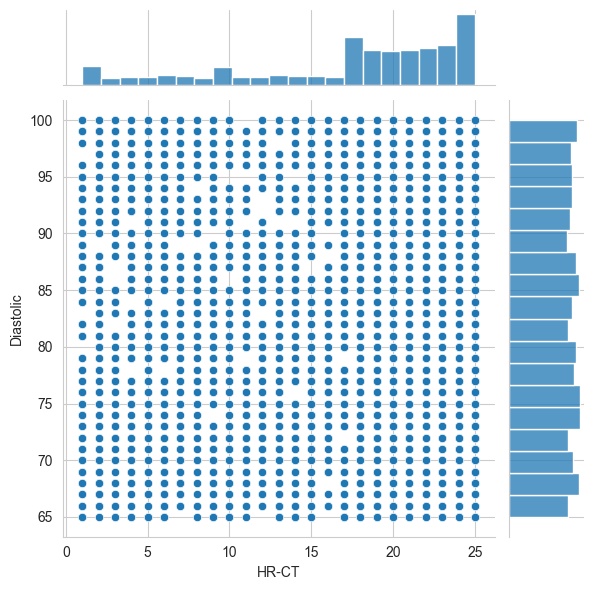

In [31]:
sns.jointplot(x='HR-CT', y='Diastolic', data=data_dropped_encoded, kind='scatter')
plt.show()

#### Heatmap

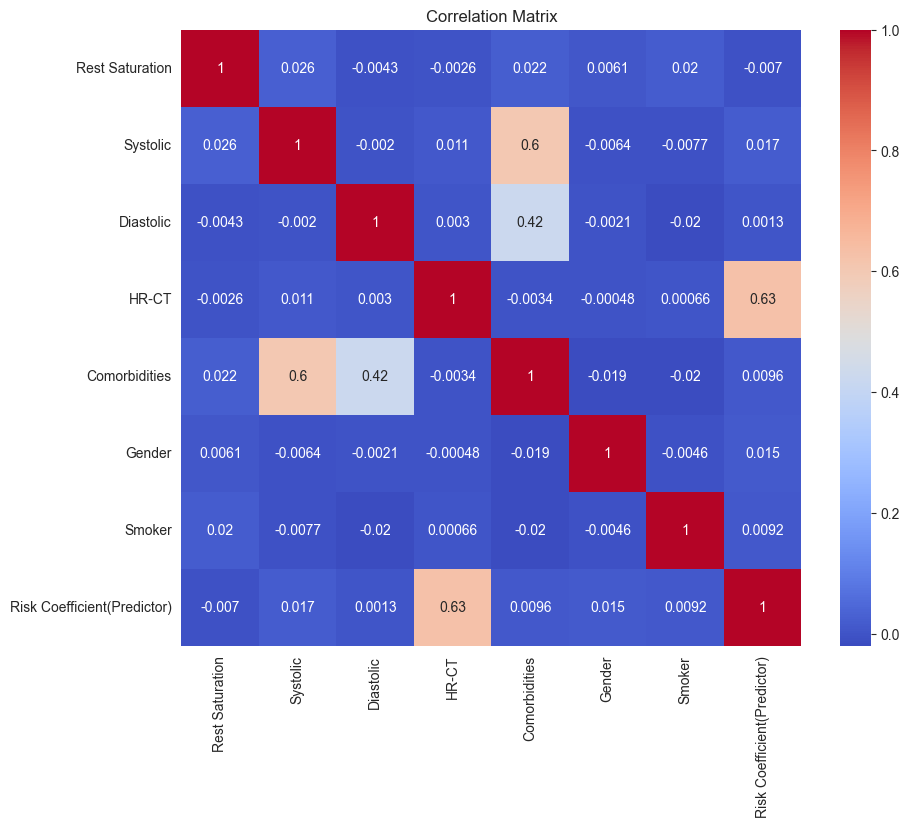

In [32]:
correlation_matrix = data_dropped_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Multivariate Analysis

#### Multivariate analysis involves examining more than two variables simultaneously to understand their relationships and combined effects. This type of analysis is essential for uncovering complex interactions in data.


#### Contour Plot


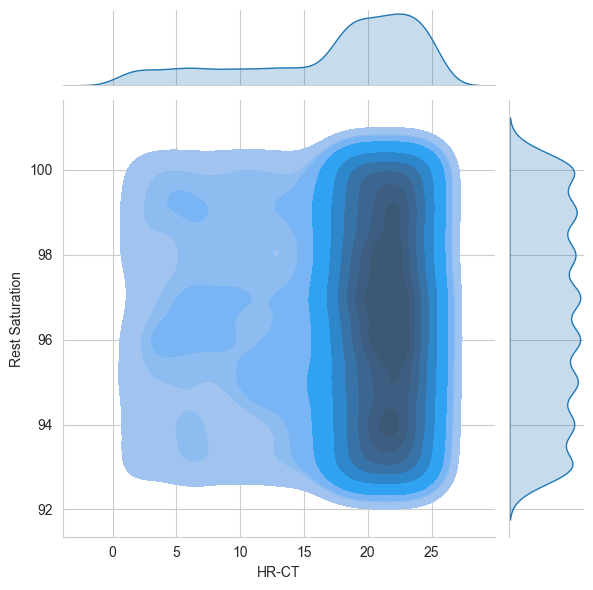

In [33]:
sns.jointplot(x='HR-CT', y='Rest Saturation', data=data_dropped_encoded, kind='kde', fill=True)
plt.show()

#### 3D Scatter Plot


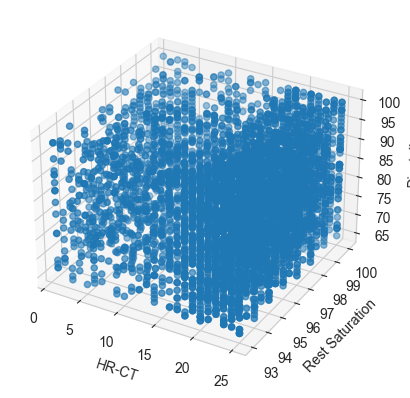

In [34]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_dropped_encoded['HR-CT'], data_dropped_encoded['Rest Saturation'], data_dropped_encoded['Diastolic'])
ax.set_xlabel('HR-CT')
ax.set_ylabel('Rest Saturation')
ax.set_zlabel('Diastolic')

plt.show()

### Model Training and Evaluation

In [35]:
# Function to train and evaluate models
def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf_model = RandomForestClassifier(random_state=42)
    knn_model = KNeighborsClassifier()
    rf_model.fit(X_train, y_train)
    knn_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    y_pred_knn = knn_model.predict(X_test)
    rf_accuracy = accuracy_score(y_test, y_pred_rf)
    knn_accuracy = accuracy_score(y_test, y_pred_knn)
    return rf_accuracy, knn_accuracy

In [36]:
# Separate features and target variable
X_dropped = data_dropped_encoded.drop(columns=['Risk Coefficient(Predictor)'])
y_dropped = data_dropped_encoded['Risk Coefficient(Predictor)']

X_interpolated = data_interpolated_encoded.drop(columns=['Risk Coefficient(Predictor)'])
y_interpolated = data_interpolated_encoded['Risk Coefficient(Predictor)']

X_imputed = data_imputed_encoded.drop(columns=['Risk Coefficient(Predictor)'])
y_imputed = data_imputed_encoded['Risk Coefficient(Predictor)']

In [37]:
# Train and evaluate models on each dataset
rf_accuracy_dropped, knn_accuracy_dropped = train_and_evaluate(X_dropped, y_dropped)
rf_accuracy_imputed, knn_accuracy_imputed = train_and_evaluate(X_imputed, y_imputed)
rf_accuracy_interpolated, knn_accuracy_interpolated = train_and_evaluate(X_interpolated, y_interpolated)

In [38]:
# Output the results
print(f"Random Forest Accuracy (Dropped): {rf_accuracy_dropped}")
print(f"KNN Accuracy (Dropped): {knn_accuracy_dropped}")
print(f"Random Forest Accuracy (Imputed): {rf_accuracy_imputed}")
print(f"KNN Accuracy (Imputed): {knn_accuracy_imputed}")
print(f"Random Forest Accuracy (Interpolated): {rf_accuracy_interpolated}")
print(f"KNN Accuracy (Interpolated): {knn_accuracy_interpolated}")

Random Forest Accuracy (Dropped): 0.8141592920353983
KNN Accuracy (Dropped): 0.8072763028515241
Random Forest Accuracy (Imputed): 0.8333333333333334
KNN Accuracy (Imputed): 0.7911764705882353
Random Forest Accuracy (Interpolated): 0.8352941176470589
KNN Accuracy (Interpolated): 0.7931372549019607


In [39]:
# Additional strategies: Drop one column at a time, then impute others
columns_to_drop = numerical_columns + categorical_columns
additional_accuracies = []

for column in columns_to_drop:
    temp_data = data_cleaned.drop(columns=[column]).copy()
    for col in numerical_columns:
        if col in temp_data.columns:
            temp_data[col].fillna(temp_data[col].median(), inplace=True)
    for col in categorical_columns:
        if col in temp_data.columns:
            temp_data[col].fillna(temp_data[col].mode()[0], inplace=True)
    temp_data_encoded = encode_data(temp_data)
    X_temp = temp_data_encoded.drop(columns=['Risk Coefficient(Predictor)'])
    y_temp = temp_data_encoded['Risk Coefficient(Predictor)']
    rf_acc, knn_acc = train_and_evaluate(X_temp, y_temp)
    additional_accuracies.append((f"Drop {column}", rf_acc, knn_acc))

In [40]:
# Drop two columns at a time and impute the rest
for i in range(len(columns_to_drop)):
    for j in range(i+1, len(columns_to_drop)):
        columns = [columns_to_drop[i], columns_to_drop[j]]
        temp_data = data_cleaned.drop(columns=columns).copy()
        for col in numerical_columns:
            if col in temp_data.columns:
                temp_data[col].fillna(temp_data[col].median(), inplace=True)
        for col in categorical_columns:
            if col in temp_data.columns:
                temp_data[col].fillna(temp_data[col].mode()[0], inplace=True)
        temp_data_encoded = encode_data(temp_data)
        X_temp = temp_data_encoded.drop(columns=['Risk Coefficient(Predictor)'])
        y_temp = temp_data_encoded['Risk Coefficient(Predictor)']
        rf_acc, knn_acc = train_and_evaluate(X_temp, y_temp)
        additional_accuracies.append((f"Drop {columns[0]}, {columns[1]}", rf_acc, knn_acc))

In [41]:
for method, rf_acc, knn_acc in additional_accuracies:
    print(f"Random Forest Accuracy ({method}): {rf_acc}")
    print(f"KNN Accuracy ({method}): {knn_acc}")

Random Forest Accuracy (Drop Rest Saturation): 0.8068627450980392
KNN Accuracy (Drop Rest Saturation): 0.7823529411764706
Random Forest Accuracy (Drop Systolic): 0.8098039215686275
KNN Accuracy (Drop Systolic): 0.796078431372549
Random Forest Accuracy (Drop Diastolic): 0.8
KNN Accuracy (Drop Diastolic): 0.8019607843137255
Random Forest Accuracy (Drop HR-CT): 0.5186274509803922
KNN Accuracy (Drop HR-CT): 0.49117647058823527
Random Forest Accuracy (Drop Comorbidities): 0.8343137254901961
KNN Accuracy (Drop Comorbidities): 0.7901960784313725
Random Forest Accuracy (Drop Gender): 0.8254901960784313
KNN Accuracy (Drop Gender): 0.788235294117647
Random Forest Accuracy (Drop Smoker): 0.8274509803921568
KNN Accuracy (Drop Smoker): 0.788235294117647
Random Forest Accuracy (Drop Rest Saturation, Systolic): 0.7901960784313725
KNN Accuracy (Drop Rest Saturation, Systolic): 0.8117647058823529
Random Forest Accuracy (Drop Rest Saturation, Diastolic): 0.7735294117647059
KNN Accuracy (Drop Rest Satura

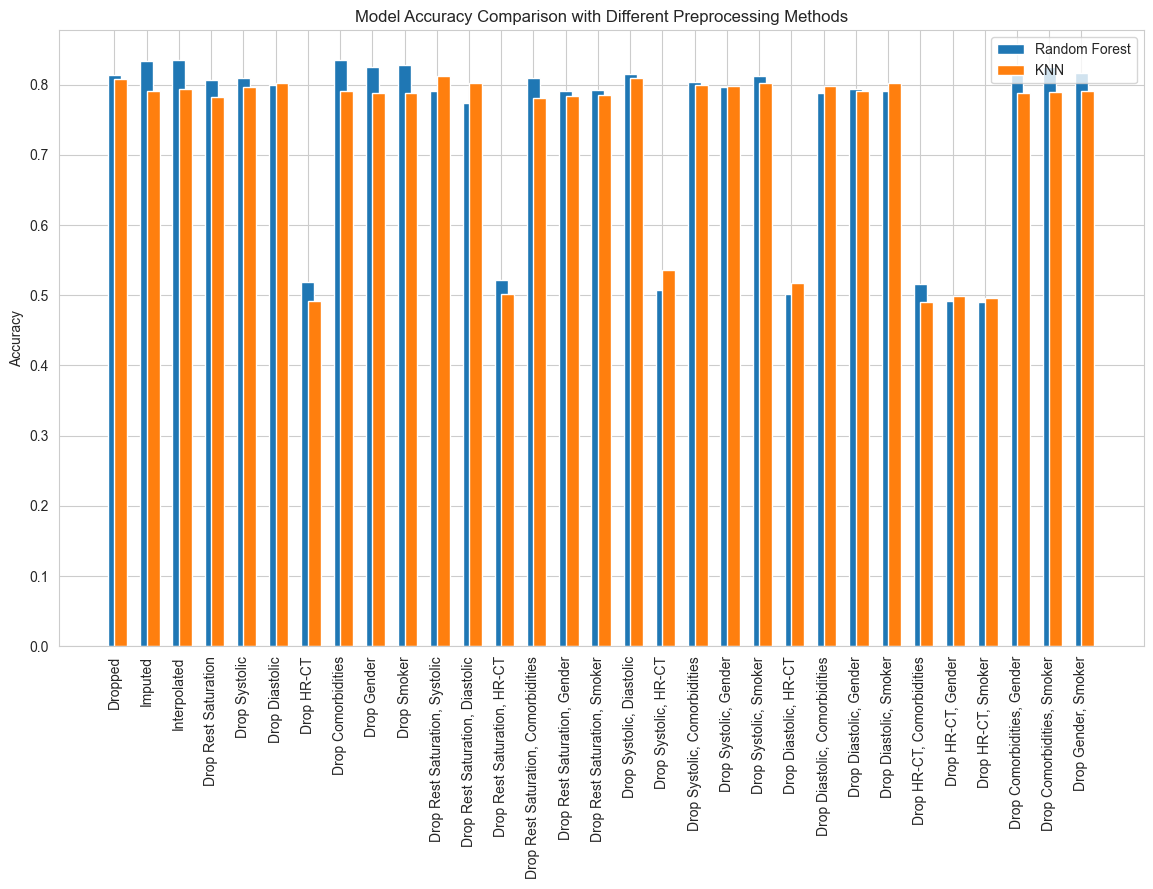

In [42]:
# Bar plot for model accuracies
methods = ['Dropped', 'Imputed', 'Interpolated'] + [item[0] for item in additional_accuracies]
rf_accuracies = [rf_accuracy_dropped, rf_accuracy_imputed, rf_accuracy_interpolated] + [item[1] for item in additional_accuracies]
knn_accuracies = [knn_accuracy_dropped, knn_accuracy_imputed, knn_accuracy_interpolated] + [item[2] for item in additional_accuracies]

plt.figure(figsize=(14, 8))
x = range(len(methods))
plt.bar(x, rf_accuracies, width=0.4, label='Random Forest', align='center')
plt.bar(x, knn_accuracies, width=0.4, label='KNN', align='edge')
plt.xticks(x, methods, rotation=90)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison with Different Preprocessing Methods')
plt.legend()
plt.show()

# Colinearity and MultiCollinearity

In [43]:
data_dropped_encoded

,Rest Saturation,Systolic,Diastolic,HR-CT,Comorbidities,Gender,Smoker,Risk Coefficient(Predictor)
0,96.0,118.0,78.0,21.0,1,0,1,1
1,98.0,140.0,67.0,20.0,0,1,0,0
2,96.0,135.0,83.0,22.0,1,1,0,1
3,97.0,118.0,86.0,25.0,1,0,1,1
4,95.0,120.0,88.0,3.0,0,1,1,0
...,...,...,...,...,...,...,...,...
5095,100.0,160.0,68.0,19.0,1,0,1,1
5096,99.0,118.0,66.0,20.0,0,1,1,1
5097,98.0,129.0,66.0,22.0,0,1,0,1
5098,97.0,150.0,76.0,23.0,1,1,0,1


## Approach 1
### Drop one column from the pair having correlation greater than 0.4

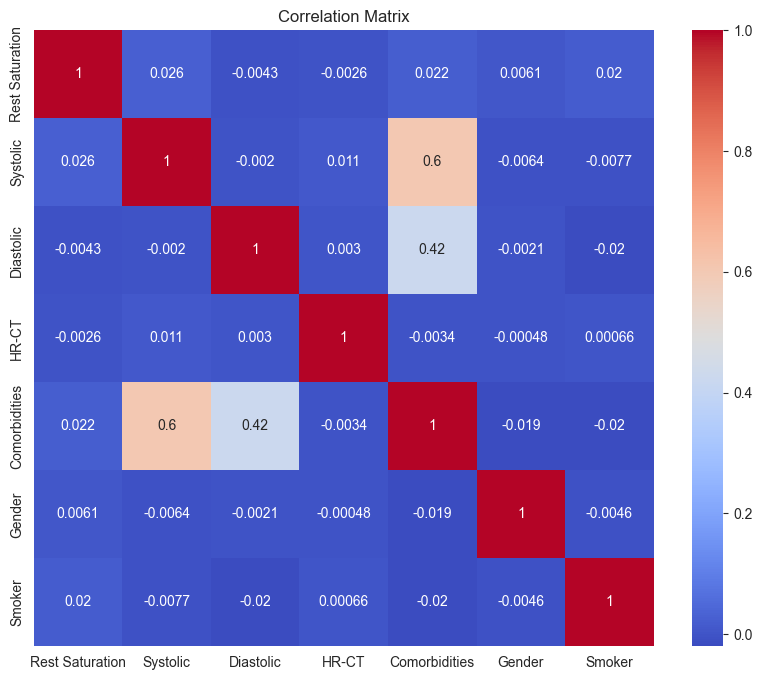

[('Comorbidities', 'Systolic'), ('Comorbidities', 'Diastolic')]


In [44]:
# function for checking pair with high correlation

def check_correaltion_pair(dataset, threshold, target):
    correlated_pair = []
    dataset1 = dataset.copy()
    dataset1 = dataset1.drop(columns=[target])
    correlation_matrix = dataset1.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i,j]) > threshold:
                feature1 = correlation_matrix.columns[i]
                feature2 = correlation_matrix.columns[j]
                correlated_pair.append((feature1,feature2))
                
    return correlated_pair

correlation_matrix = data_dropped_encoded.corr()
pair = check_correaltion_pair(data_dropped_encoded, 0.4, 'Risk Coefficient(Predictor)')
print(pair)

In [45]:
X_dropped = data_dropped_encoded.drop(columns=['Risk Coefficient(Predictor)','Comorbidities']).dropna()
y_dropped = data_dropped_encoded['Risk Coefficient(Predictor)']

In [46]:
X_dropped

,Rest Saturation,Systolic,Diastolic,HR-CT,Gender,Smoker
0,96.0,118.0,78.0,21.0,0,1
1,98.0,140.0,67.0,20.0,1,0
2,96.0,135.0,83.0,22.0,1,0
3,97.0,118.0,86.0,25.0,0,1
4,95.0,120.0,88.0,3.0,1,1
...,...,...,...,...,...,...
5095,100.0,160.0,68.0,19.0,0,1
5096,99.0,118.0,66.0,20.0,1,1
5097,98.0,129.0,66.0,22.0,1,0
5098,97.0,150.0,76.0,23.0,1,0


In [47]:
rf_accuracy_dropped, knn_accuracy_dropped = train_and_evaluate(X_dropped, y_dropped)


In [48]:
# Output the results
print(f"Random Forest Accuracy (Dropped): {rf_accuracy_dropped}")
print(f"KNN Accuracy (Dropped): {knn_accuracy_dropped}")

Random Forest Accuracy (Dropped): 0.8210422812192724
KNN Accuracy (Dropped): 0.8043264503441495


## Approach 2
### apply VIF and keep on recursively dropping feature with VIF > threshold
### drop one column at a time andd then again compute VIF

In [49]:
data_dropped_encoded.head()

,Rest Saturation,Systolic,Diastolic,HR-CT,Comorbidities,Gender,Smoker,Risk Coefficient(Predictor)
0,96.0,118.0,78.0,21.0,1,0,1,1
1,98.0,140.0,67.0,20.0,0,1,0,0
2,96.0,135.0,83.0,22.0,1,1,0,1
3,97.0,118.0,86.0,25.0,1,0,1,1
4,95.0,120.0,88.0,3.0,0,1,1,0


In [50]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [51]:
X = data_dropped_encoded.iloc[:,:-1]
calc_vif(X)

,variables,VIF
0,Rest Saturation,249.479994
1,Systolic,138.552157
2,Diastolic,82.318043
3,HR-CT,7.408124
4,Comorbidities,4.737034
5,Gender,1.946131
6,Smoker,2.023762


In [52]:
X = X.drop(columns=['Rest Saturation'])
calc_vif(X)

,variables,VIF
0,Systolic,41.787831
1,Diastolic,38.129524
2,HR-CT,7.301337
3,Comorbidities,2.763220
4,Gender,1.941882
5,Smoker,2.014194


In [53]:
X = X.drop(columns=['Systolic'])
calc_vif(X)

,variables,VIF
0,Diastolic,10.763537
1,HR-CT,6.835891
2,Comorbidities,2.603703
3,Gender,1.923983
4,Smoker,1.989761


In [54]:
X = X.drop(columns=['Diastolic'])
calc_vif(X)

,variables,VIF
0,HR-CT,3.001329
1,Comorbidities,2.004661
2,Gender,1.765852
3,Smoker,1.821503


In [55]:
X

,HR-CT,Comorbidities,Gender,Smoker
0,21.0,1,0,1
1,20.0,0,1,0
2,22.0,1,1,0
3,25.0,1,0,1
4,3.0,0,1,1
...,...,...,...,...
5095,19.0,1,0,1
5096,20.0,0,1,1
5097,22.0,0,1,0
5098,23.0,1,1,0


In [56]:
y_dropped = data_dropped_encoded['Risk Coefficient(Predictor)']
y_dropped

0       1
1       0
2       1
3       1
4       0
       ..
5095    1
5096    1
5097    1
5098    1
5099    1
Name: Risk Coefficient(Predictor), Length: 5085, dtype: int64

In [57]:
rf_accuracy_dropped, knn_accuracy_dropped = train_and_evaluate(X, y_dropped)


In [58]:
# Output the results
print(f"Random Forest Accuracy (Dropped): {rf_accuracy_dropped}")
print(f"KNN Accuracy (Dropped): {knn_accuracy_dropped}")

Random Forest Accuracy (Dropped): 0.8456243854473943
KNN Accuracy (Dropped): 0.8338249754178958
